# Analyzing the Bank Marketing Dataset to evaluate the impact of marketing decisions.
The [UCI Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) comes from a real-world bank's direct marketing campaign. It is a popular dataset most commonly treated as a classification task, to predict whether a client will open a term deposit account. In this notebook, we show that it is equally suitable for causal inference. The fraction of clients making term deposits is an outcome that the bank would like to increase, and the dataset contains several variables that could be seen as interventions or treatments for doing so.



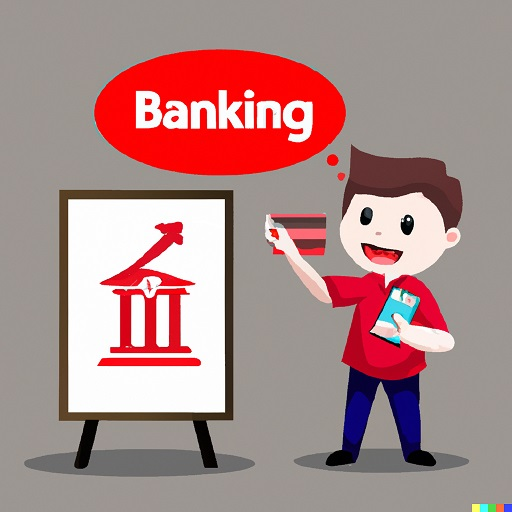

---

# Table of Contents

1. Understand Data
  1. Identify treatment variables
  2. Identify potential confounders
2. Effect of Contact Mode
  1. Inverse propensity weighting: First attempt

  3. Inverse propensity weighting: After excluding non-overlap region
  4. Standardization
  5. Summary and comparison with non-causal analysis
3. Effect of Number of Contacts
  1. Redefine treatment variable and potential confounders
  2. A closer look at the intervention scenario
  3. Inverse propensity weighting
  4. Standardization
  5. Summary and comparison with non-causal analysis

---

# 1. Understand Data
Load the data:

In [ ]:
import numpy as np
import pandas as pd

def read_data_from_UCI():
    """Reads the bank-marketing data table from a zip file directly from UCI"""
    import zipfile
    import io
    from urllib import request

    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
    with request.urlopen(url) as r:
        with zipfile.ZipFile(io.BytesIO(r.read())) as zf:
            csv_file = zf.open("bank-additional/bank-additional-full.csv")
            df = pd.read_csv(csv_file, sep=";")
    return df

In [ ]:
data = read_data_from_UCI()
data.shape

(41188, 21)

The first step is to understand what variables are present in the data.

In [ ]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

According to the data description:

* The first seven variables ('age'-'loan') relate to the client, including basic credit characteristics ('default', 'housing', 'loan').
* The next four variables relate to the last contact with the client during the current campaign: the mode of communication ('contact', cellular/telephone), date ('month', 'day_of_week'), and duration of the contact ('duration'). 'campaign' is the number of contacts made during this campaign.
* The three subsequent variables relate to previous marketing campaigns, if applicable: the number of days since the last contact from a previous campaign ('pdays'), the number of contacts in previous campaigns ('previous'), and their outcome ('poutcome').
* Variables 'emp.var.rate'-'nr.employed' are economic indicators such as the employment rate and consumer price index.
* The last variable 'y' is the outcome of whether the client opened a term deposit.

We go ahead and binarize 'y', mapping 'yes' to value 1.

In [14]:
print(data['y'].unique())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = pd.Series(le.fit_transform(data['y']))
y.mean()

['no' 'yes']


0.11265417111780131


Only 11.3% of clients sign up for a term deposit.

## Identify treatment variables
Next, we consider which of the above variables could be regarded as interventions, undertaken by bank employees, to increase the rate of positive outcomes. These are immediately limited to the variables associated with the current campaign, since client characteristics and economic conditions cannot be controlled by the bank, nor can past events be changed. In addition, as discussed here, 'duration' is not known until the last contact is completed and is mostly determined by the client. Of the remaining variables, in this notebook we will investigate the effects of 'contact' (mode of communication) and 'campaign' (number of contacts). 'day_of_week' can be treated similarly as 'contact', as indicated below.

We consider 'contact' first and encode it as a 0/1-valued variable a (0 for cellular, 1 for telephone):

In [15]:
print(data['contact'].unique())
a = pd.Series(le.fit_transform(data['contact']))
a.mean()

['telephone' 'cellular']


0.3652520151500437

## Identify potential confounders
To estimate causal effects from observational data, we must also identify which of the variables are potential confounders, variables that could affect both the outcome 'y' as well as the decision to intervene. We will want to "adjust for" (i.e. control) these confounders to isolate the causal effect of the intervention on 'y'. For this dataset, confounder selection can be done by:

1. Following the rule of thumb of avoiding post-intervention variables, i.e., those that may be affected by the intervention, and
2. Putting ourselves in the shoes of the hypothetical bank employee who made the decision.

Consideration 1 eliminates 'duration' since it is a result of the last contact with the client. On the flip side, we will always include as potential confounders:

* Client characteristics 'age'-'loan': These clearly affect the client's decision to invest in a term deposit (the outcome). We assume that the bank may also have most of this information in their records and a bank employee may consult it in contacting the client.
* Previous campaigns 'pdays', 'previous', 'poutcome': These indicate the client's previous receptiveness to the bank's products and would also be part of the client's record.
* Economic indicators 'emp.var.rate'-'nr.employed': These conditions may influence the client's decision as well as the bank's practices.

In [16]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

For the 'contact' intervention, the decision is whether the bank employee should call a cell phone or landline as the next (and last) contact with the client. Thus we will also include as potential confounders 'month', to account for any seasonality effects, and 'campaign', the number of contacts up until this point.

In [17]:
confounders += ['month', 'campaign']

We will discuss the 'campaign' intervention later below.

Now we just extract the confounders into a variable X and dummy-code (aka one-hot code) the categorical ones in preparation for modelling.

In [18]:
X = data[confounders]
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
month              object
campaign            int64
dtype: object

In [19]:
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)
X.head()

,age,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,campaign,job=blue-collar,...,poutcome=success,month=aug,month=dec,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
0,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,57,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,37,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,40,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,56,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,...,0,0,0,0,0,0,1,0,0,0


---

# 2. Effect of Contact Mode
We have actually done a good part of the hard work, namely understanding the data and identifying the treatment variables and confounders. Now we can put the tools of Causal Inference 360 to work.

We will first study the causal effect of contact mode 'contact'. Specifically, we will consider the average causal effect, comparing the rate of positive outcomes (term deposits opened) that would result if everyone had been contacted by cell phone versus the rate if everyone had been contacted by landline.

We will estimate the effect in two different ways: inverse propensity weighting (IPW) and standardization. You can look at their respective notebooks (IPW, standardization) for more details on each and also try a third method on your own, namely doubly robust regression. Recall that in causal inference from observational data, the true causal effect is never known: for each client, we observe only one outcome corresponding to the intervention they were assigned, and we cannot go back in time and run a randomized experiment (randomly assigning clients to interventions). By estimating the effect in different ways, relying on different assumptions, we can increase confidence in the results we obtain if they are close to each other.

### Inverse propensity weighting: First attempt
Inverse propensity weighting (IPW) requires a model for estimating the probabilities of treatment assignments given the confounders X (known as propensities). Here we will start with plain logistic regression.

In [20]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)

Fit the model:

In [21]:
ipw.fit(X, a)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

Estimating the rates of positive outcomes under the two interventions (0 if everyone is contacted by cell phone, 1 by landline) is then simply a matter of calling the estimate_population_outcome method of the IPW object.

In [22]:
outcomes = ipw.estimate_population_outcome(X, a, y)
outcomes

0    0.156409
1    0.221426
dtype: float64

However, before we accept this result, we have to check the IPW model for any problems that we can detect with the observed data. We do this using Causal Inference 360's evaluation plots.

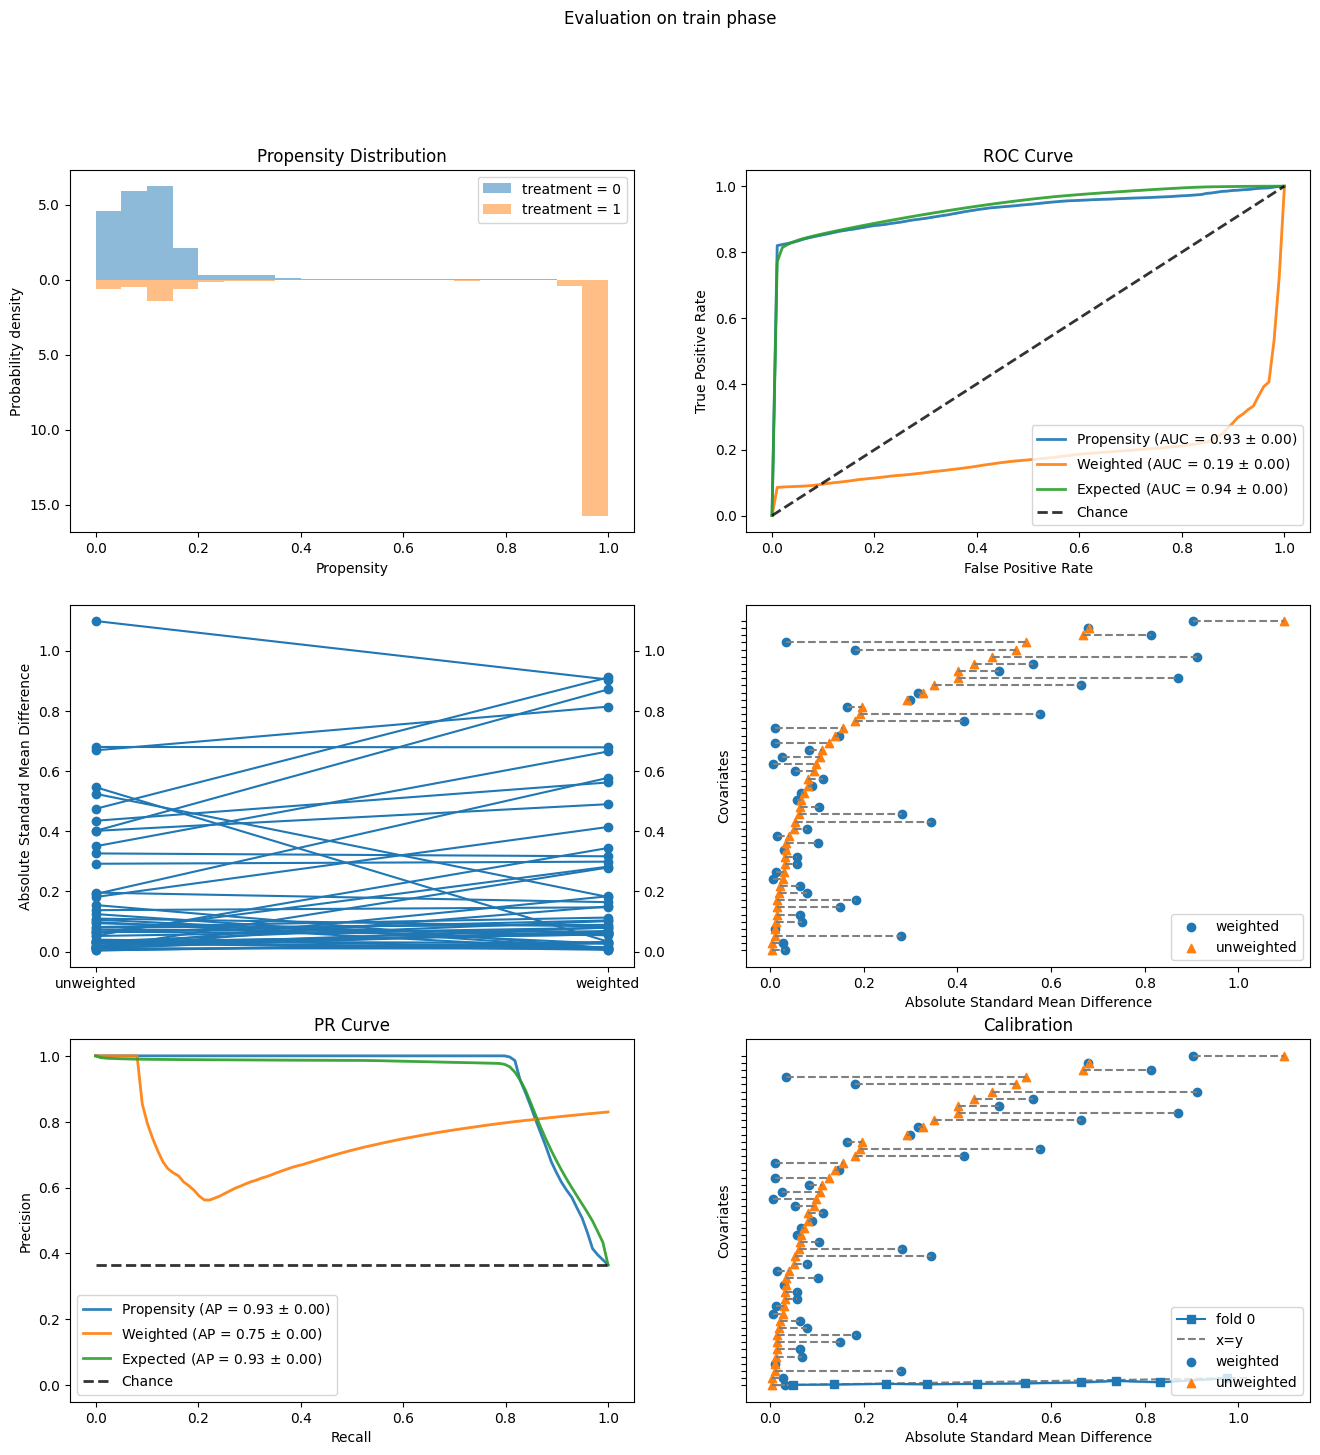

In [23]:
%matplotlib inline
from causallib.evaluation import evaluate

eval_results = evaluate(ipw, X, a, y)
eval_results.plot_all()
eval_results.plot_covariate_balance(kind="love");

The evaluation plots show the following problems:
* **ROC Curve**: The blue curve labelled "Propensity" is the standard ROC for predicting treatment `a` from the confounders `X`. In normal classification, we want a high AUC value close to 1, but for causal inference, an AUC that is too high (0.93 here) indicates that the two treatment groups (cellular/telephone) are too easily separated. In particular, the vertical segment at the left end of the ROC indicates that we can correctly identify a large fraction of telephone contacts (true positives) with hardly any cellular contacts mixed in (false positives). In addition, the orange curve labelled "Weighted" should ideally have an AUC of 0.5, meaning that the two treatment groups become indistinguishable after the propensity weighting is applied. The current AUC of 0.19 is way off.
* **Propensity Distribution**: This plot shows the distributions of propensity values for `a=1` (estimated probability of being contacted by telephone) for the two treatment assignment groups: cellular (blue) and telephone (orange). The large orange bars at the right without any blue bars above them again point to the existence of a population that was essentially always contacted by telephone and never by cellular.
* **Covariate Balance** (bottom left): The orange triangles in this plot (called a *Love plot*) show that the two treatment groups have large differences in the mean values of some of the covariates (confounders). Re-plotting the Love plot by itself, we see that the largest differences are in the economic indicators `'cons.price.idx'`, `'euribor3m'`, `'emp.var.rate'`. Furthermore, the propensity weighting has not really succeeded in reducing these differences (blue circles).

Taken together, the plots show a *lack of overlap* between the two treatment groups, and specifically a group of clients that was almost always contacted by telephone. It is not advisable to estimate causal effects in regions where we do not have treatment overlap, unless we are willing to make strong assumptions about how outcomes extrapolate from one region to another (i.e., what would be the outcome under the cellular treatment for the group that was always contacted by telephone).


### Inverse propensity weighting: After excluding non-overlap region
We now re-fit and re-evaluate the IPW model after removing the non-overlap region identified above.

In [24]:
ipw.fit(X, a)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

{'train': {'weight_distribution': <Axes: title={'center': 'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'roc_curve': <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'covariate_balance_slope': <Axes: ylabel='Absolute Standard Mean Difference'>,
  'covariate_balance_love': <Axes: xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>,
  'pr_curve': <Axes: title={'center': 'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'calibration': <Axes: title={'center': 'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>}}

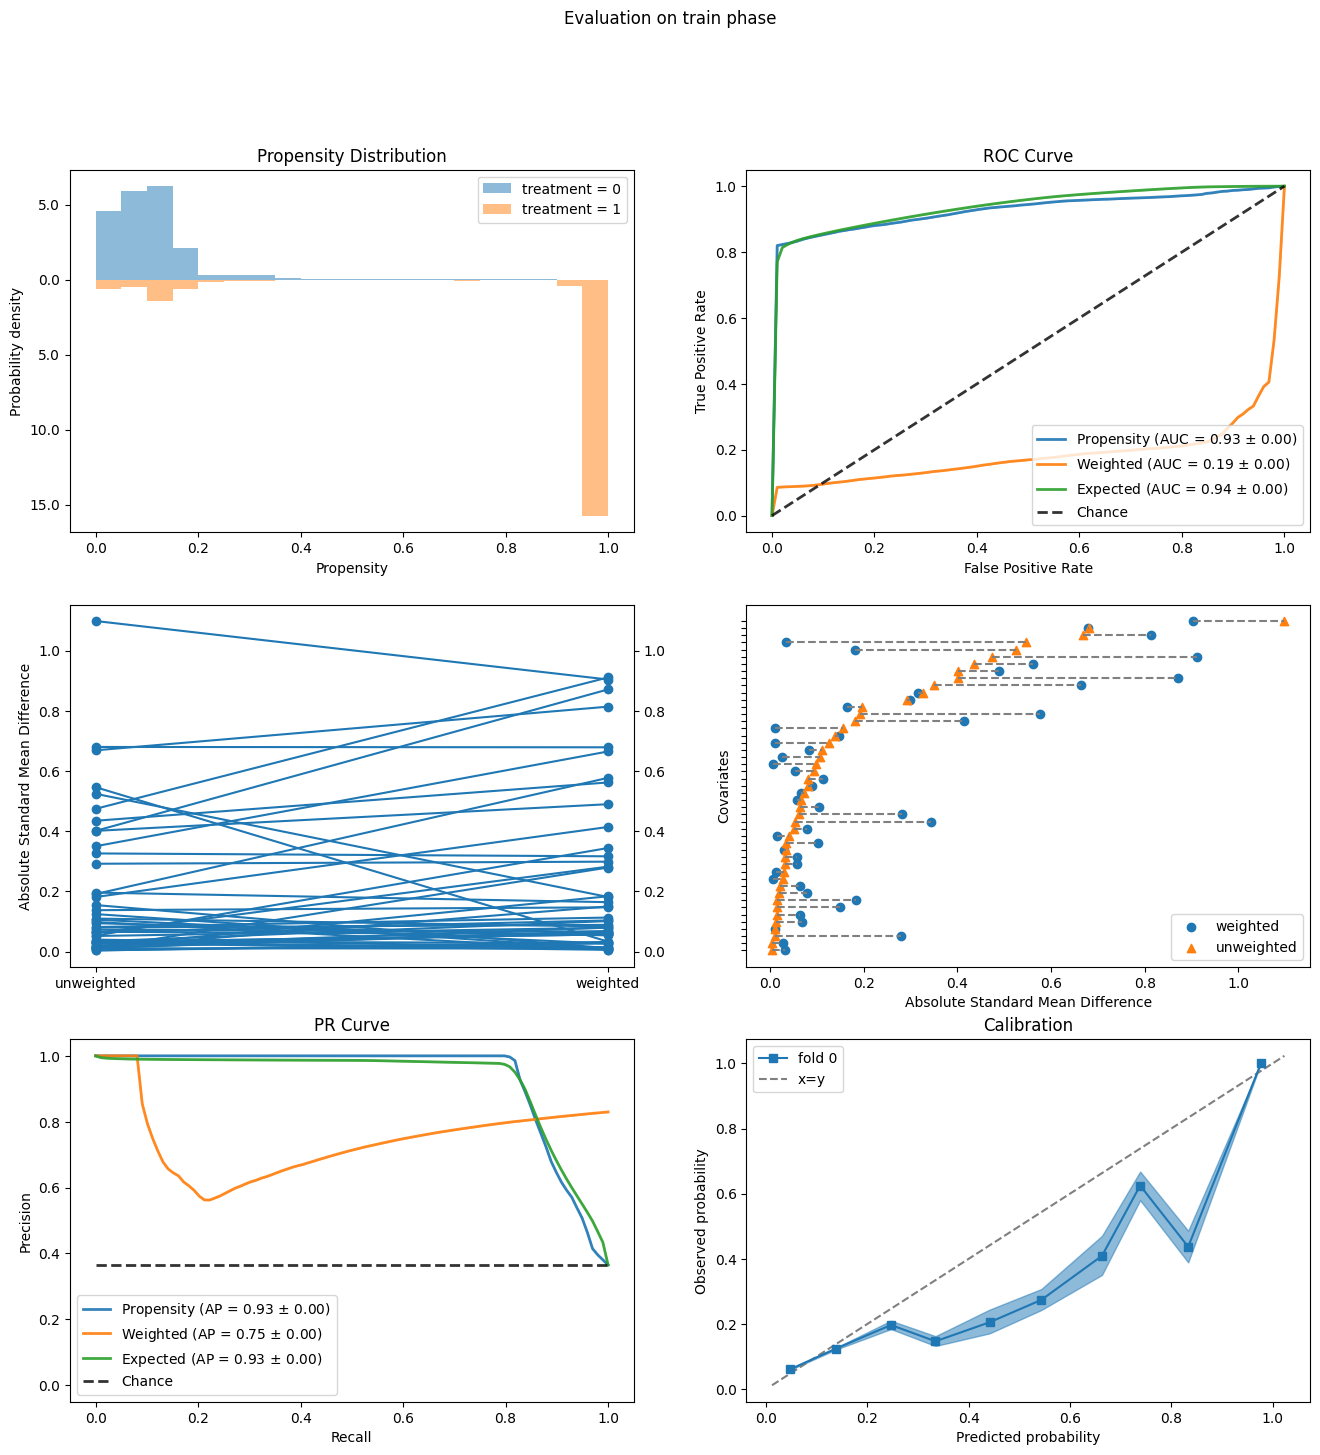

In [25]:
eval_results = evaluate(ipw, X, a, y)
eval_results.plot_all()

The evaluation looks much better.

* **ROC Curve**: The original AUC of 0.68 ("Propensity", blue curve) is not too high, and the weighted AUC (orange) is close to 0.5.
* **Propensity** Distribution: No more large orange bars that do not overlap with blue ones.
* **Covariate Balance Love Plot**: The starting mean differences are now much smaller, below 0.3 on this standardized scale, and are decreased to below 0.1 by propensity weighting.
* **Calibration**: The calibration curve does deviate significantly from the ideal y=x line. However, this occurs above a predicted probability of 0.3, which the Propensity Distribution plot above shows is very infrequent, so it is not too much of a concern.

Armed with greater confidence from these improved evaluation plots, we re-estimate the rates of positive outcomes under the two interventions.

In [26]:
outcomes = ipw.estimate_population_outcome(X, a, y)
print(outcomes)
ipw.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

0    0.156409
1    0.221426
dtype: float64


diff    -0.065017
ratio    0.706372
dtype: float64

We conclude from the IPW analysis that contacting clients by cell phone results in a higher rate of opening term deposits than by landline, 15% to 12%, a difference of 3.0% and a relative increase of almost 25%.

### Standardization
Next we turn to standardization as a second method for estimating the causal effect of contact mode. We will continue to exclude the telephone-only group identified above to avoid having to extrapolate.

Standardization requires a model for estimating the outcome y given intervention a and confounders X. We will use gradient-boosted classification trees as well as the predict_proba=True option to focus on predicting probabilities of outcomes.

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from causallib.estimation import Standardization

#gb = LinearRegression()
gb = GradientBoostingClassifier()
std = Standardization(gb, predict_proba=True)
std.fit(X, a, y)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Standardization(encode_treatment=False, predict_proba=True,
                learner=GradientBoostingClassifier())

In [28]:
outcomes = std.estimate_population_outcome(X, a).xs(1, level='y')
print(outcomes)
std.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


a
0    0.118945
1    0.090685
dtype: float64


diff     0.028260
ratio    1.311631
dtype: float64

These values are similar to the ones obtained with IPW: an absolute increase of 3.4% in positive outcomes with cellular contact compared to landline, and a relative increase of 29%.

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


{'train': {'roc_curve': <Axes: title={'center': 'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'calibration': <Axes: title={'center': 'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'pr_curve': <Axes: title={'center': 'PR Curve'}, xlabel='Recall', ylabel='Precision'>}}

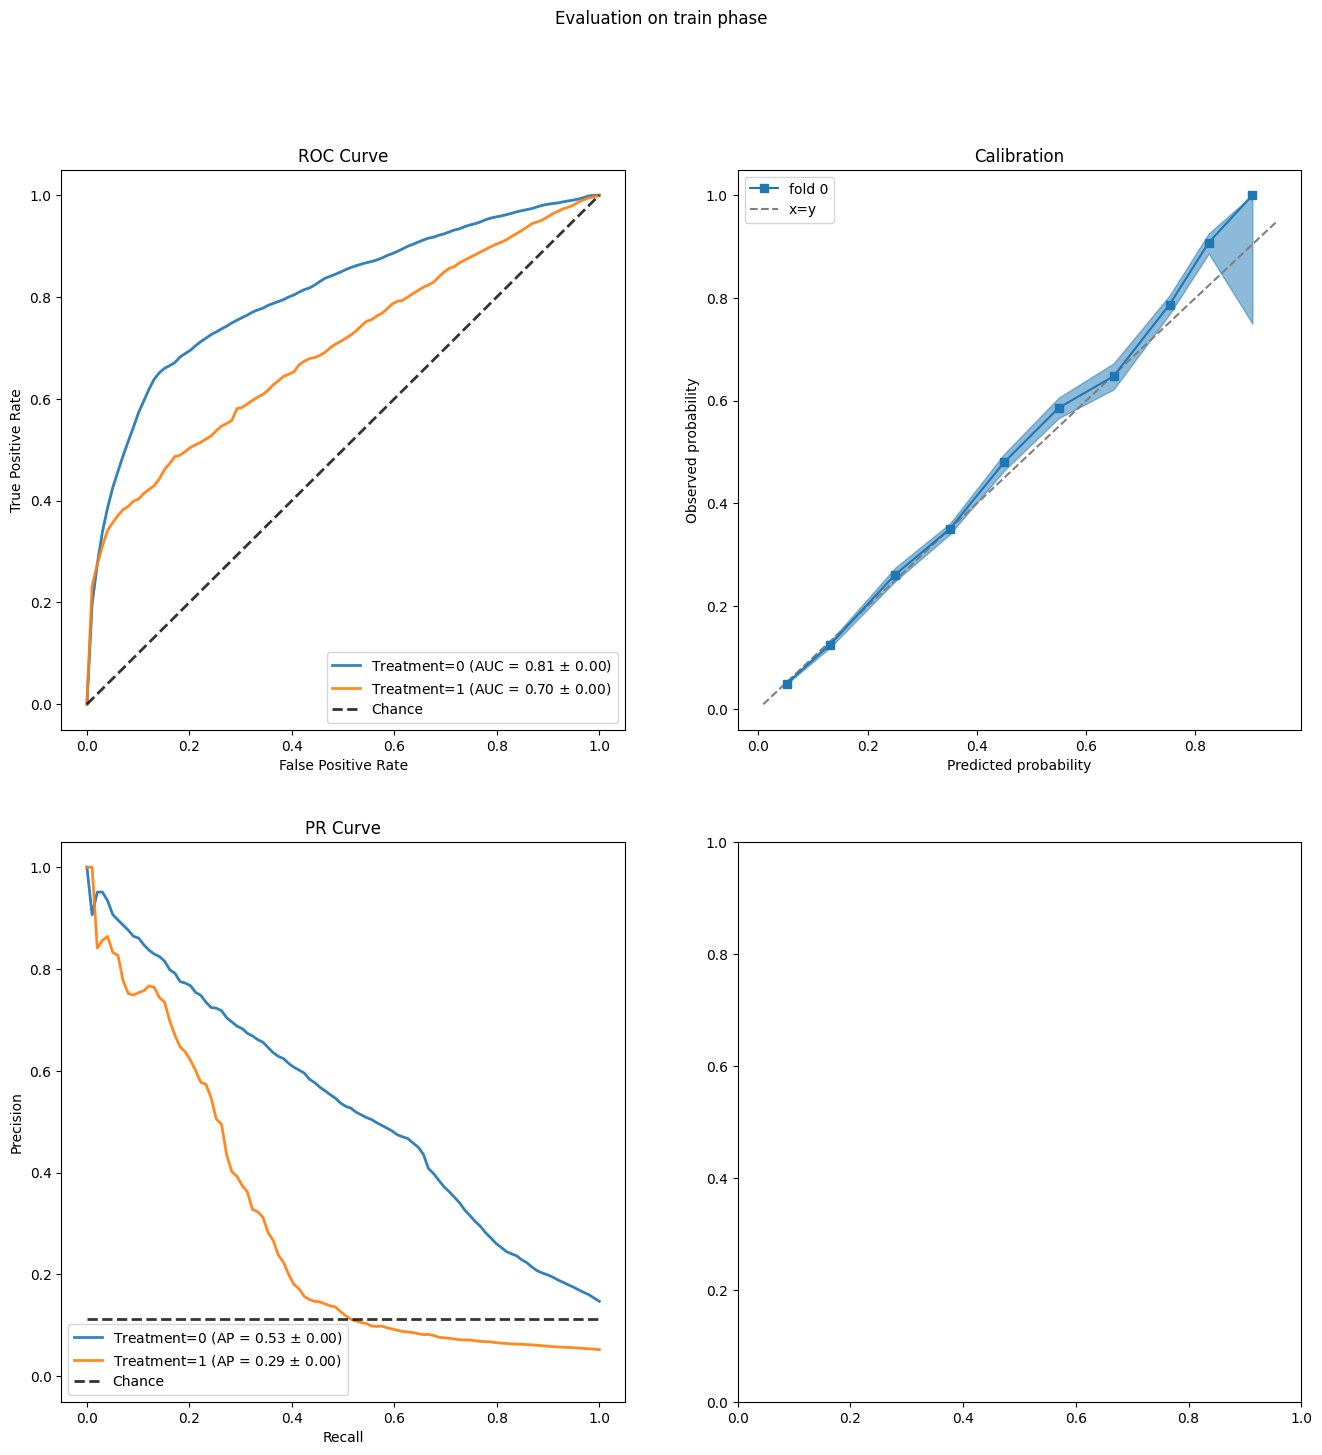

In [29]:
eval_results = evaluate(std, X, a, y)
eval_results.plot_all()

* **ROC Curve**: The AUC in predicting outcome `y` is reasonably high and similar for both treatment groups. 
* **Predicted Common Support**: This plot is meant to assess the ignorability assumption, which states that the counterfactual outcomes (Y<sup>0</sup>, Y<sup>1</sup>) are independent of the actual treatment assignment when conditioned on the confounders. The plot shows the distributions of predicted (Y<sup>0</sup>, Y<sup>1</sup>) values and we are looking for good overlap between the distributions for treatment groups 0 (blue) and 1 (orange). This appears to be the case.

The `Standardization` class uses a single regressor that takes input (`X`, `a`) to predict `y`, i.e., the intervention `a` is placed on the same footing as other input features in `X`. Alternatively, `StratifiedStandardization` uses two regressors, one for `a=0` and one for `a=1`, each of which take `X` as input.

In [30]:
from causallib.estimation import StratifiedStandardization
std = StratifiedStandardization(gb, predict_proba=True)
std.fit(X, a, y)

outcomes = std.estimate_population_outcome(X, a).xs(1, level='y')
print(outcomes)
std.estimate_effect(outcomes[0], outcomes[1], effect_types=['diff','ratio'])

a
0    0.122219
1    0.090482
dtype: float64


diff     0.031737
ratio    1.350748
dtype: float64

---


# 3. Effect of Number of Contacts

We turn now to studying the effect of the number of contacts made in the current marketing campaign, `'campaign'`, on the rate of positive outcomes. Specifically, we will estimate the success rates that would result if all clients were contacted more than once versus just once.  It is a relevant question because contacting clients takes resources (e.g. employee time). Together with other inputs, the effect estimate could inform instructions to employees on whether to continue contacting clients after a first attempt, or spend their time more profitably on other tasks.


### Redefine treatment variable and potential confounders

We accordingly redefine the treatment variable `a` to be 1 if `'campaign'` is greater than 1 and 0 if `'campaign'` is equal to 1. We also have to redefine `y` to restore the non-overlap group that was excluded above when we were considering the contact mode. 

In [31]:
y = pd.Series(le.fit_transform(data['y']))
a = (data['campaign'] > 1).astype(int)
print(y.mean())
print(a.mean())

0.11265417111780131
0.5716713605904632


As for confounders, we continue to use the client characteristics, previous campaign features, and economic indicators included before.

In [32]:
confounders = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

With `'campaign'` as the treatment, we imagine that we are making the decision to stop or continue after the first contact with the client. In this scenario, the features of the last contact (`'contact'`, `'day_of_week'`, and certainly `'duration'`) may not be known, so they should not be considered as potential confounders. We will thus only add `'month'`.

In [33]:
confounders += ['month']

Re-extracting the confounders:

In [34]:
X = data[confounders]
X = pd.get_dummies(X, prefix_sep='=', drop_first=True)

### A closer look at the intervention scenario

Let us stop and think a bit harder about the decision-making scenario: we contact all clients once, and then decide whether to continue contacting or stop. The first observation is that the rate of positive outcomes can only increase by continuing, so there is no question about the sign of the treatment effect. Rather, the goal is to estimate how large the positive rate is under the decision to continue, to inform a cost-benefit analysis. 

Second, the main challenge in causal effect estimation (the "fundamental problem of causal inference") is that we generally cannot observe *counterfactual* outcomes: for individuals given intervention `a=0`, we do not observe their outcomes under `a=1`, and vice versa. In the present scenario however, we actually can deduce several counterfactual outcomes. Let us define Y<sup>0</sup> as the *potential outcome* that would result if a client were contacted only once. For clients actually contacted once (assigned `a=0`), their observed outcome `y` is the same as the potential outcome Y<sup>0</sup>. For clients contacted more than once (assigned `a=1`), if we had instead stopped after the first contact, their potential outcomes should be Y<sup>0</sup> = 0, as otherwise the bank employees would not have persisted in contacting them. Thus, Y<sup>0</sup> can be inferred for all clients as follows:

In [35]:
y0 = y * (a == 0)
y0.mean()

0.05584150723511702

This 5.6% success rate is in fact the rate under the intervention of contacting only once. We will come back to it later.

In addition, the potential outcome Y<sup>0</sup> is **known** at the time of decision after the first contact by the bank employees. It can in fact be seen as a special kind of confounder in having deterministic effects: if Y<sup>0</sup>=1 (success), then `a=0` deterministically as there is no benefit to continuing, and also `y=1`. Since clients with Y<sup>0</sup>=1 receive only treatment `a=0`, they constitute a group with **complete non-overlap** of treatments. They should therefore be excluded from the causal analysis, as we did before in the analysis of `'contact'`. So we remove them:

In [36]:
y = y.loc[y0 == 0]
a = a.loc[y0 == 0]
X = X.loc[y0 == 0]
X.shape

(38888, 46)

The remaining clients with Y<sup>0</sup>=0 can receive either treatment `a=0` or `a=1`, so they do not exhibit complete non-overlap. They might still suffer from partial non-overlap, but this can be checked using an IPW model and Causal Inference 360's evaluation methods, as we will do in the next subsection.

One more thing to keep in mind is that the treatment `a=1`, i.e., `'campaign' > 1`, is actually a *composite* treatment: It is not a well-defined intervention like "contact exactly twice," but rather "contact more than once according to the distribution of `'campaign'` in the data" (in other words, following what the bank employees collectively did). Indeed, one might imagine that after some number of contacts, the success rate would start to decline because clients become irritated or may even leave the bank (an outcome we do not observe in the data). In this notebook, we will not address these additional considerations and will focus on the simplified case of a binarized treatment.

### Inverse propensity weighting

As in Section 2, we will instantiate IPW with a logistic regression model for predicting the probabilities of treatment assignments.

In [37]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
#lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
#lr = GradientBoostingClassifier()
ipw = IPW(lr)
ipw.fit(X, a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=1000))

Let us check the IPW model using the evaluation plots:

<Axes: title={'center': 'Calibration'}, xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>

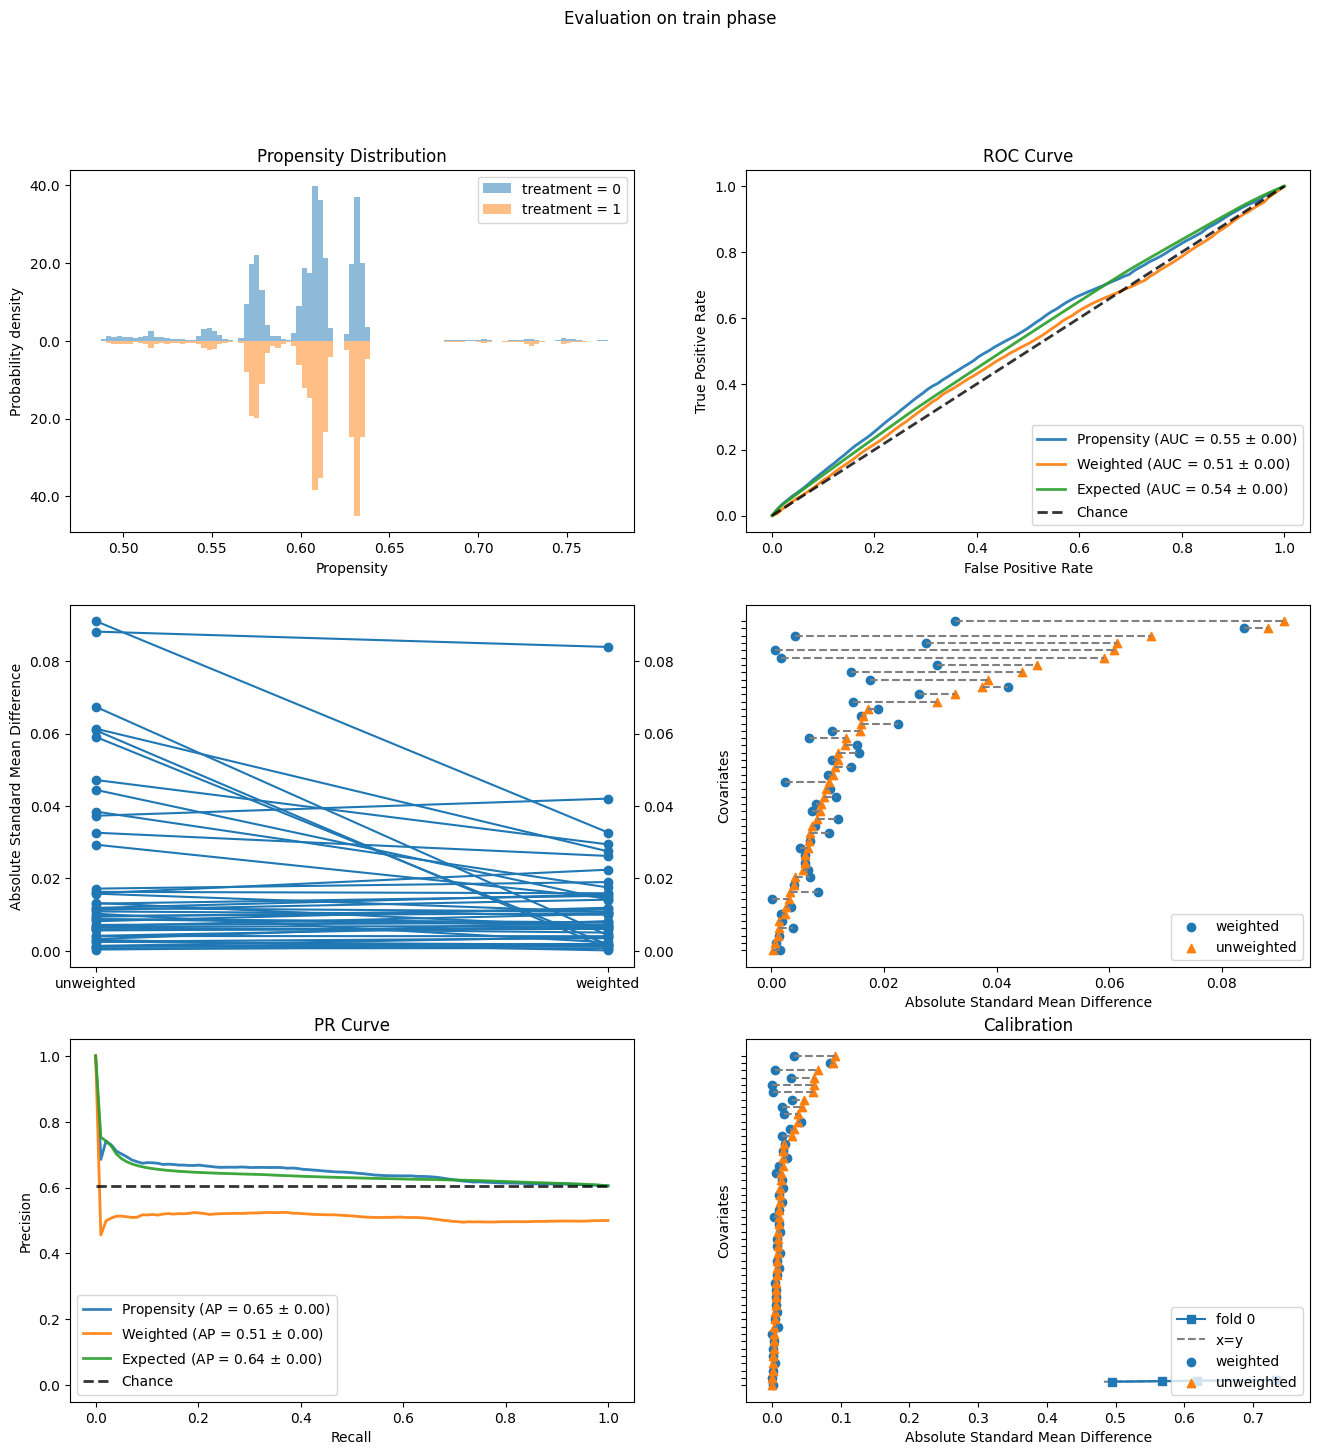

In [38]:
eval_results = evaluate(ipw, X, a, y)
eval_results.plot_all()
eval_results.plot_covariate_balance(kind="love")

The two treatment groups are fairly balanced to begin with: 
* **ROC Curve**: The Propensity AUC (blue curve) is only 0.55, which is further reduced to 0.51 by IPW.
* **Propensity Distribuution**: The distributions of propensity estimates are balanced.
* **Covariate Balance Love Plot**: The standardized mean differences are all below 0.1 even before IPW.

Now we obtain estimates of positive rates and the treatment effect:

In [39]:
outcomes = ipw.estimate_population_outcome(X, a, y)
print(outcomes)
ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=['diff'])

0    0.000000
1    0.100092
dtype: float64


diff    0.100092
dtype: float64

The positive rate is zero under `a=0` (stopping), as it should be for this subpopulation defined by the lack of success after one contact. Under `a=1`, the estimated success rate is 10%. We will break down this rate next using standardization.

### Standardization

Recall that in standardization, we use a regressor to predict the outcome `y` from confounders `X` and treatment `a`. Because of the exclusion of positive outcomes Y<sup>0</sup>=1 under `a=0`, `y` is now identically zero conditioned on `a=0`. Thus we need only fit a model for `a=1`. To accomplish this, we use `StratifiedStandardization` with gradient boosted classification trees as before for `a=1` and linear regression for `a=0`. The latter is a "dummy" that will just return an all-zero model.

In [40]:
from sklearn.linear_model import LinearRegression
std = StratifiedStandardization({0: LinearRegression(), 1: GradientBoostingClassifier()}, predict_proba=True)
std.fit(X, a, y)

StratifiedStandardization(learner=LinearRegression())

We go ahead and estimate rates of positive outcomes under the two interventions. (The last two columns of `outcomes` are the predicted probabilities of `y=0` and `y=1` under intervention `a=1` and hence add up to 1.)

In [41]:
outcomes = std.estimate_population_outcome(X, a)
print(outcomes)
std.estimate_effect(outcomes[(1,1)], outcomes[0], effect_types=['diff'])

campaign   
0         y    0.000000
1         0    0.902181
          1    0.097819
dtype: float64


diff    0.097819
dtype: float64

The estimated outcome under the `a=0` intervention (stopping) is zero, as expected. The estimated outcome of 9.8% under `a=1` is slightly lower than that from IPW.

With standardization, we can also see whether there is a difference between the estimated success rates for the **assigned** treatment groups `a=0` and `a=1`, under the intervention of continuing contact for all clients. This can be done using the `estimate_individual_outcome` method (as opposed to `estimate_population_outcome` above), extracting the `(1,1)` column with success probabilities under the `a=1` intervention, and then averaging the probabilities over the two treatment groups.

In [42]:
yPot = std.estimate_individual_outcome(X, a)#.xs(1, axis=1, level='y')
#print(yPot.head())
y1 = yPot[(1,1)]
print('Estimated success rates under continuing contact')
print('for the "untreated" group a=0: {}'.format(y1.loc[a == 0].mean()))
print('for the "treated" group a=1: {}'.format(y1.loc[a == 1].mean()))

Estimated success rates under continuing contact
for the "untreated" group a=0: 0.09540979275929169
for the "treated" group a=1: 0.09938921214795549


The average of `y1` over the `a=0` group (the potential success rate in the "untreated") is slightly lower than that of the `a=1` group (the "treated"), which accounts for the slightly lower overall rate of 9.8% above. What this means is that if we had decided to continue contacting **all** clients, we might have had slightly less success with the clients whom the bank employees stopped contacting in the data (`a=0`) than with the clients whom they continued to contact (`a=1`). Perhaps this is because the bank employees, in deciding whom to keep contacting, had some ability to predict which clients would be more likely to invest, although we cannot say this with confidence given the small difference.

We can also verify that the estimated success rate for the `a=1` group is very close to the observed rate (since this group was actually subject to continued contact). The latter is the rate *conditioned on* `a=1`. Again, this may be what one would compute without a causal approach.

In [43]:
print(y[a==1].mean())

0.09937993714431326


---

#Conclusion


### Summary and comparison with non-causal analysis

Recall that we had excluded from the causal analysis clients with a positive outcome after the first contact (Y<sup>0</sup>=1). For these clients, we can assume (or define) their counterfactual outcome to be Y<sup>1</sup>=1 if we were to keep contacting them. Then we can construct a complete set of potential outcomes `y1All` under the `a=1` intervention:

In [44]:
y1All = y0.copy()
y1All[y1All == 0] = y1
print('Estimated success rate under one contact for all clients: {}'.format(y0.mean()))
print('Estimated success rate under more than one contact for all clients: {}'.format(y1All.mean()))

Estimated success rate under one contact for all clients: 0.05584150723511702
Estimated success rate under more than one contact for all clients: 0.14819839345801725


In summary, from the data we observe a 5.6% success rate after one contact, and from the causal analysis, we are predicting a success rate of 14.8% if **all** clients were subject to continued contact. The observed success rate of 11.3% lies in between since the bank employees continued contacting some clients and stopped contacting others.

We conclude as before with a comparison to what might be obtained with a non-causal analysis, naively looking at the success rates *conditioned* on treatment assignments `a=0`, `a=1`. We first re-define `y` and `a` to bring back the excluded population with Y<sup>0</sup>=1.

In [45]:
y = pd.Series(le.fit_transform(data['y']))
a = (data['campaign'] > 1).astype(int)
y[a==0].mean(), y[a==1].mean()

(0.13037070626913047, 0.09937993714431326)

We see now that these conditional success rates are quite misleading. They seem to indicate that the success rate would be lower if clients were contacted more than once, which we know is not true (even from common sense). Breaking down the two cases:
* For `a=0`, the rate of 13.0% is from only those clients whom the bank employees contacted once. But had they stopped at one contact for the remaining clients, they would have had no additional successes. Thus, the success rate under the *intervention* of exactly one contact is much lower, 5.6% from above. 
* For `a=1`, the rate of 9.9% is close to the 9.8% that we estimated using |standardization for those clients that were not successes after the first contact (Y<sup>0</sup>=0). However, we must remember to add back the clients who already agreed to a term deposit after the first contact (Y<sup>0</sup>=1), and that gives us the success rate of 14.8% above under the *intervention* of more than one contact.
---

In this notebook, we have explored the concept of causality in machine learning and the importance of understanding causal inference. Through our analysis of the UCI Bank Marketing dataset, we applied various causal inference techniques, including inverse propensity weighting (IPW) and standardization, to estimate the causal effect of different interventions on the outcome variable. Our goal was to evaluate the impact of marketing decisions on whether a client will open a term deposit account.

Key Findings from the Causal Analysis:
1. We identified the treatment variables and potential confounders, emphasizing the importance of correct identification in causal inference.
2. We analyzed the effect of contact mode on the treatment outcome using causal inference techniques, finding that the choice of contact mode could significantly impact the marketing campaign's success.
3. We implemented IPW and standardization to estimate the causal effect of the interventions, observing that the estimated causal effects differed between the methods, but both provided valuable insights into the relationships between the variables.


# License  

All code in this notebook is available as open source through the MIT license.

All text and images are free to use under the Creative Commons Attribution 3.0 license.  https://creativecommons.org/licenses/by/3.0/us/

These licenses let people distribute, remix, tweak, and build upon the work, even commercially, as long as they give credit for the original creation.

Copyright 2023 AI Skunks  https://github.com/aiskunks

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.